## Preparing data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./penguins_size.csv', skipinitialspace=True).dropna().drop(['sex', 'body_mass_g'], axis=1)

island_encoder = {
    'Torgersen': 1,
    'Biscoe': 2,
    'Dream': 3
}
# one hot encoding
species_encoder = {
    'Adelie': 0,
    'Gentoo': 1,
    'Chinstrap': 2
}
df['island'] = df['island'].map(island_encoder)
df['species'] = df['species'].map(species_encoder)

df = df.dropna().reindex()

df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm
0,0,1,39.1,18.7,181.0
1,0,1,39.5,17.4,186.0
2,0,1,40.3,18.0,195.0
4,0,1,36.7,19.3,193.0
5,0,1,39.3,20.6,190.0
...,...,...,...,...,...
338,1,2,47.2,13.7,214.0
340,1,2,46.8,14.3,215.0
341,1,2,50.4,15.7,222.0
342,1,2,45.2,14.8,212.0


# analyze

In [3]:
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
species_groups = df.groupby('species')

In [5]:
species_groups.describe()

island                                              culmen_length_mm  \
         count      mean       std  min  25%  50%  75%  max            count   
species                                                                        
0        146.0  2.054795  0.836914  1.0  1.0  2.0  3.0  3.0            146.0   
1        120.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0            120.0   
2         68.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0             68.0   

                    ... culmen_depth_mm       flipper_length_mm              \
              mean  ...             75%   max             count        mean   
species             ...                                                       
0        38.823973  ...          19.000  21.5             146.0  190.102740   
1        47.542500  ...          15.725  17.3             120.0  217.233333   
2        48.833824  ...          19.400  20.8              68.0  195.823529   

                                                       
              std    min    25%    50%     75%    max  
species                                                
0        6.521825  172.0  186.0  190.0  195.00  210.0  
1        6.557738  203.0  212.0  216.0  221.25  231.0  
2        7.131894  178.0  191.0  196.0  201.00  212.0  

[3 rows x 32 columns]

<Axes: >

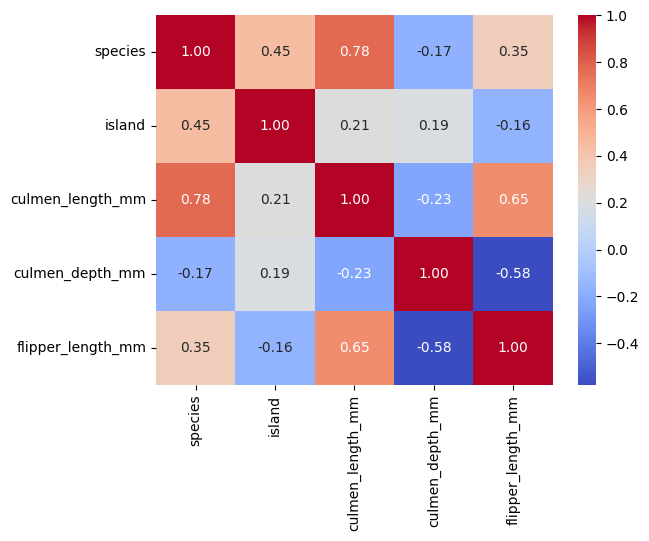

In [6]:


#corr = df.drop(['species'], axis=1).scatter_matrix()

corr_matrix = df.select_dtypes(include=['number']).corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

Appears the culmen_length_mm is highly correlated to the species

<Axes: >

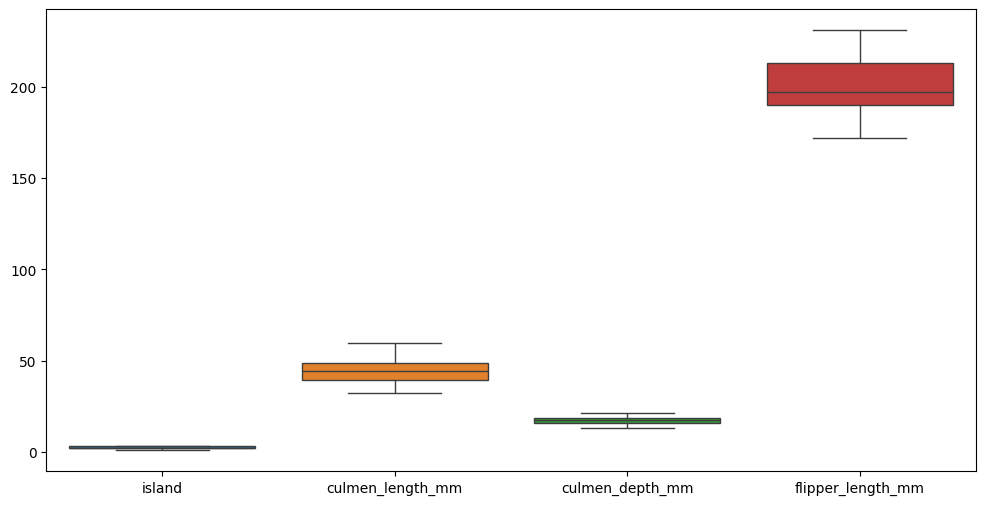

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(df.drop(['species'], axis=1))

array([[<Axes: title={'center': 'species'}>,
        <Axes: title={'center': 'island'}>],
       [<Axes: title={'center': 'culmen_length_mm'}>,
        <Axes: title={'center': 'culmen_depth_mm'}>],
       [<Axes: title={'center': 'flipper_length_mm'}>, <Axes: >]],
      dtype=object)

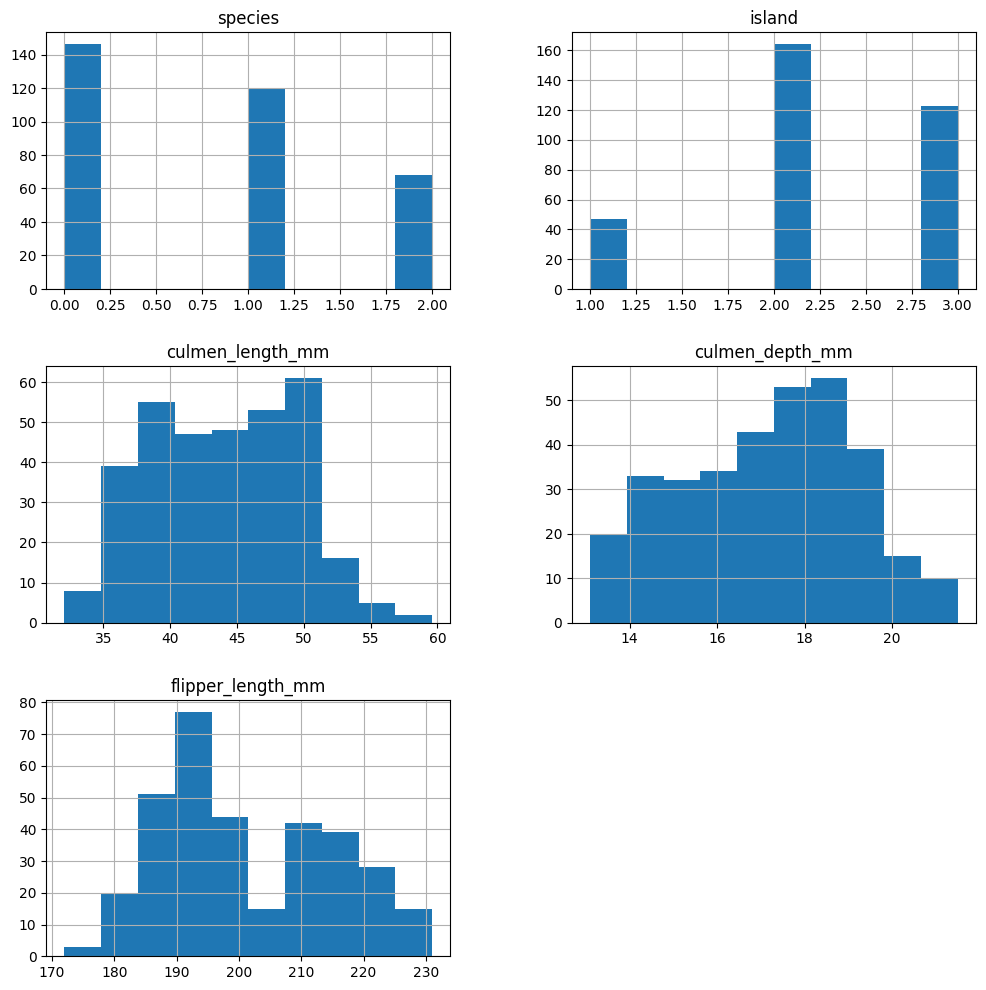

In [8]:
df.hist(figsize=(12,12))

# MLP to predict species

In [9]:
from mlp import MultilayerPerceptron, Layer, Linear, SquaredError, LeakyRelu, Relu, Softmax, CrossEntropy
from sklearn.model_selection import train_test_split
import numpy as np

In [10]:
X = df.drop(['species'], axis=1).to_numpy()
y =df['species'].to_numpy()

# one hot encode 3 cases of classification
y = np.eye(3)[y]

X

array([[  1. ,  39.1,  18.7, 181. ],
       [  1. ,  39.5,  17.4, 186. ],
       [  1. ,  40.3,  18. , 195. ],
       ...,
       [  2. ,  50.4,  15.7, 222. ],
       [  2. ,  45.2,  14.8, 212. ],
       [  2. ,  49.9,  16.1, 213. ]])

In [11]:


X_train, X_leftover, y_train, y_leftover = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42)
# Split the remaining 30% into validation/testing (15%/15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_leftover, y_leftover,
    test_size=0.5,
    random_state=42,
    shuffle=True,
)
X_mean = X_train.mean(axis=0)  # Mean of each feature
X_std = X_train.std(axis=0)    # Standard deviation of each feature

X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [12]:
model = MultilayerPerceptron(
    [
        Layer(fan_in = 4, fan_out = 7, activation_function=LeakyRelu()),
        Layer(fan_in = 7, fan_out = 16, activation_function=Relu()),
        Layer(fan_in = 16, fan_out = 3, activation_function=Softmax())
    ]
)


training_loss, val_loss= model.train(
    train_x = X_train,
    train_y= y_train,
    val_x= X_val,
    val_y= y_val,
    loss_func=CrossEntropy()
)


weights shape (4, 7)
bias shape (7,)
weights shape (7, 16)
bias shape (16,)
weights shape (16, 3)
bias shape (3,)
Epoch :: 1 :: Train Loss= 0.003298043742268619 :: Val Loss 0.0031374710975460795
Epoch :: 2 :: Train Loss= 0.0029506848269205844 :: Val Loss 0.002830865907341298
Epoch :: 3 :: Train Loss= 0.0026709680737345186 :: Val Loss 0.00256519003785475
Epoch :: 4 :: Train Loss= 0.0024305039003230085 :: Val Loss 0.002336939407014671
Epoch :: 5 :: Train Loss= 0.0022139917888146683 :: Val Loss 0.0021346680042567544
Epoch :: 6 :: Train Loss= 0.002024931277476256 :: Val Loss 0.0019542872034595724
Epoch :: 7 :: Train Loss= 0.0018574476921742109 :: Val Loss 0.0017971166540162026
Epoch :: 8 :: Train Loss= 0.0017142950679454416 :: Val Loss 0.0016568626237492058
Epoch :: 9 :: Train Loss= 0.001585603751787579 :: Val Loss 0.0015369299855595665
Epoch :: 10 :: Train Loss= 0.0014743487734082215 :: Val Loss 0.0014328230883339844
Epoch :: 11 :: Train Loss= 0.0013777351959272986 :: Val Loss 0.001343053

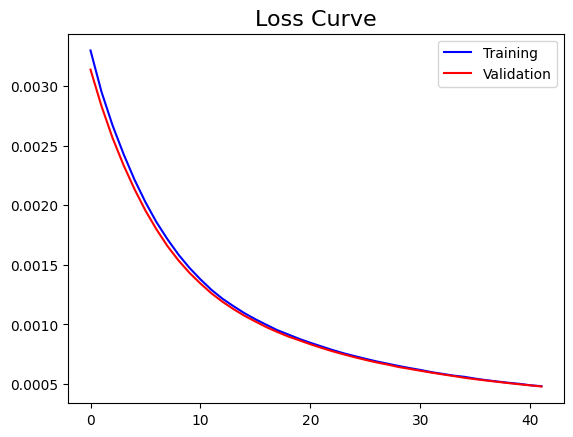

In [13]:

plt.plot(training_loss, color='b', label='Training')
plt.plot(val_loss, color='r', label="Validation")
plt.title("Loss Curve", size=16)
plt.legend()

In [14]:
predicted_labels  = np.argmax(model.forward(X_test), axis=1)
decoded_y = np.argmax(y_test, axis=1)

print("Correct", len(np.where(predicted_labels  == decoded_y)[0]), "/", len(X_test))

Correct 56 / 56
